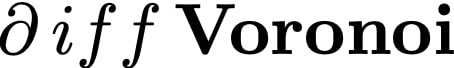

In [ ]:
%%capture
!pip install torch-geometric==2.5.0
!pip install trimesh
!pip install differentiable-voronoi
!pip install gradnorm-pytorch

In [ ]:
from differentiable_voronoi import differentiable_voronoi, triangulate
from shapely import Polygon, LineString, Point
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_dense_adj, to_undirected
from copy import deepcopy
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from trimesh import Trimesh
from scipy.spatial import Delaunay
import matplotlib.patches
from shapely.geometry.polygon import orient
from scipy.spatial import Voronoi, voronoi_plot_2d
from torch_geometric.nn.pool import avg_pool_x
import copy
from torch.nn import MSELoss
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree

### Circle

In [ ]:
import math

a = 0.5
b = 0.5
r = 0.5

#The lower this value the higher quality the circle is with more points generated
stepSize = 0.1

#Generated vertices
positions = []

t = 0
while t < 2 * math.pi:
    positions.append((r * math.cos(t) + a, r * math.sin(t) + b))
    t += stepSize

circle = torch.tensor(np.array(positions[::-1]))

In [ ]:
x_values = np.array([0, 0.05, 0.15, 0.3, 0.45, 0.55, 0.7, 0.8, 0.9, 1])
y_values = np.array([0, 0.1, 0.2, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1])
pos_x, pos_y = np.meshgrid(x_values, y_values)
coords = torch.rand(1000, 2)

In [ ]:
circle_shapely = Polygon(circle)
whether_inside_the_polygon = []
for point in coords:
    is_inside = circle_shapely.contains(Point(point))
    whether_inside_the_polygon.append(is_inside)
whether_inside_the_polygon = torch.tensor(whether_inside_the_polygon)
coords = coords[whether_inside_the_polygon]

In [ ]:
mesh = triangulate(coords)
mask = torch.full((coords.shape[0], ), False)
mask[mesh.boundary_nodes] = True

In [ ]:
COORDS = torch.tensor(coords, requires_grad=True)

In [ ]:
_, areas_dict, h, _ = differentiable_voronoi(COORDS, mesh, boundary=circle)

In [ ]:
%%time
boundary_polygon = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]])
_, areas, h, _ = differentiable_voronoi(COORDS, mesh, circle)

In [ ]:
boundary_polygon = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]])
COORDS = torch.tensor(coords, requires_grad=True)
REFERENCE_COORDS = COORDS.clone()
with torch.no_grad():
    mesh = triangulate(COORDS)
optimizer = torch.optim.Adam([COORDS], lr=0.001)
loss_curve = []

for i in range(1, 1000):
    optimizer.zero_grad()
    _, areas, h, _ = differentiable_voronoi(COORDS, mesh, circle)
    loss = torch.mean((areas - torch.mean(areas))**2)
    loss_curve.append(loss.item())
    print(i, loss, areas.min(), areas.max())
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mesh = triangulate(COORDS.clone().detach())

In [ ]:
plt.plot(loss_curve)
plt.yscale('log')

In [ ]:
!zip -r /content/ani.zip /content/ani

### Физика

 **+  Diff Solver**

In [ ]:
image = '██░░░░░░░░░░░░░░░░░░░░░░███░░░░░░░░░░░░░░░░░░░░░░███░░░░░░░▄▄▄▄▄░░░░░░░░░░███░░░░█████████▄░░░░░░░░███▄░▐██▀░░░▀███░░░░░░░░░▀█████░░░░░░░██░░░░░░░░░░░█████▄▄▄▄▄███░░░░░░░░░░░░░█████████▀░░░░░░░░░░░░░░░███░░░░░░░░░░░░░░░░░░░░░░█████▄▄▄░░░░░░░░░░░░░░░░░░▀▀███████▄░░░░░░░░░░░░░░░░░░░▀▀████░░░░░░░░░░░░░░░░░░░░░░███'
def image_to_graph(image, image_height=13):
    image_width = int(len(image)/ image_height)
    xs = np.linspace(0, 1, image_width)
    ys = np.linspace(0, 1, image_height)
    xs, ys = np.meshgrid(xs, ys)
    xs, ys = xs.flatten(), ys.flatten()
    ks = []
    for i in image:
        if i == '░': ks.append(0.01)
        else: ks.append(1)
    return np.array([xs, ys, ks]).T

def reduce_graph(graph, k, keep=None, method=KMeans):
    if method=='random':
        loop_reduced = np.random.rand(k, 2)
        kdtree = KDTree(graph[:, :2])
        nn = kdtree.query(loop_reduced, k=1)[1]
        perm = graph[:, 2][nn]
        loop_reduced = np.concatenate([loop_reduced, perm], axis=1)
    elif method=='subsampling_2':
        loop_reduced = graph[: : 2]
    elif method=='subsampling_10':
        loop_reduced = graph[: : 10]
    elif method=='subsampling_50':
        loop_reduced = graph[: : 50]
    else:
        labels = method(k, random_state=16).fit_predict(graph)
        new_labels = None
        loop_reduced = avg_pool_x(torch.tensor(labels), torch.tensor(graph), torch.ones(len(labels)))[0]

    if not torch.is_tensor(loop_reduced):
        loop_reduced = torch.tensor(loop_reduced)

    if keep is not None:
        loop_reduced = torch.cat([loop_reduced, torch.tensor(graph[keep])], dim=0)
        loop_reduced, return_inverse, count = torch.unique(loop_reduced, return_inverse=True, return_counts=True,  dim=0)
    for i, p in enumerate(loop_reduced):
        for j, n in enumerate(loop_reduced):
            if i != j and torch.norm(p - n) < 1e-4:
                print(p, n)
                raise ValueError

    return loop_reduced.detach().numpy(), [return_inverse[-2].item(), return_inverse[-1].item()]

def plot_diagram(points, ax, title=''):
    vor = Voronoi(points[:, :2])
    voronoi_plot_2d(vor, ax=ax, show_vertices=False)
    ax.set_title(title)
    bar1 = ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], vmax=1, vmin=0, s=100)
    for i, txt in enumerate(points):
        ax.annotate(i, (points[i][0].item(), points[i][1].item()), fontsize=10, c='red')
    plt.colorbar(bar1, ax=ax)

eps = 1e-1
unit_boundary = torch.tensor([[-eps,-eps],[-eps, 1. + eps],[1. + eps, 1. + eps],[1. + eps, -eps]], requires_grad=False)
source_sink_loop = [0, 180]
loop = image_to_graph(image)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_diagram(loop, ax)

In [ ]:
class Solver(MessagePassing):
    """Graph solver class"""
    def __init__(self):
        super().__init__(aggr='add', flow='target_to_source')

    def calc_weights(self, k, e, h, edge_index):
        k_i, k_j = k[edge_index[0]], k[edge_index[1]]
        numerator = 2 * k_i * k_j * e
        denominator = (k_i + k_j) * h + 1e-8
        assert numerator.shape == denominator.shape
        return torch.divide(numerator, denominator)

    def forward(self, u, v, h, e, k, w, p_bhp, dt, edge_index):
        assert ~torch.any(torch.isnan(u))
        assert ~torch.any(torch.isnan(v))
        assert ~torch.any(torch.isnan(h))
        assert ~torch.any(torch.isnan(e))
        assert ~torch.any(torch.isnan(k))
        assert len(u) == len(v), print(len(u), len(v))
        assert len(h) == len(e) == edge_index.shape[1]
        assert len(u) == len(p_bhp) == len(w) == len(k)
        assert torch.all(u >= 0)
        assert torch.all(v > 0)
        assert torch.all(h > 0)
        assert torch.all(e >= 0)
        assert torch.all(k > 0)
        assert torch.all(w >= 0)
        assert torch.all(p_bhp >= 0)


        weights = self.calc_weights(k, e, h, edge_index).view(-1, 1)
        assert ~torch.any(torch.isnan(weights))
        assert len(weights) == edge_index.shape[1], print(len(weights), len(edge_index))
        edge_index, weights = to_undirected(edge_index, weights)
        assert torch.all(weights >= 0)

        div = self.propagate(edge_index=edge_index, x=u, weights=weights)
        assert len(div) == len(u)
        t_over_V = dt / v
        numerator = u + t_over_V * (w * p_bhp - div)
        denominator = 1 + t_over_V * w
        return numerator / denominator

    def message(self, x_i, x_j, weights):
        du = x_i - x_j
        return weights * du

def calc_h(coords, edge_index):
    x_i, x_j = coords[edge_index[0]], coords[edge_index[1]]
    return torch.norm(x_i - x_j, dim=1)

In [ ]:
def roll_out(solver, n_steps, u0, v, h, e, k, w, p_bhp, dt, edge_index, keep=0, save_animation=False, every_nth=10000):
    roll = torch.zeros(n_steps)
    animation=[]
    u = u0
    for i in range(n_steps):
        u = Solver()(u=u, v=v.view(-1, 1), h=h, e=e, k=k, w=w, p_bhp=p_bhp, dt=dt, edge_index=edge_index)
        roll[i] = u[keep]
        if save_animation and i%every_nth==0: animation.append(u)
    return roll, animation

def dynamics(point_cloud, ids, boundary, dt=0.0001, n_steps=10000, save_animation=False):
    COORDS = torch.tensor(point_cloud[:, :2], dtype=torch.float32, requires_grad=False)
    mesh = triangulate(COORDS.clone().detach())

    edge_index, areas, e, _ = differentiable_voronoi(COORDS, mesh, boundary)
    assert len(COORDS) == len(areas), print(len(COORDS), len(areas), areas)
    h = calc_h(COORDS, edge_index)

    u0 = torch.zeros((len(COORDS), 1), requires_grad=False)
    perm = torch.tensor(point_cloud[:, 2], requires_grad=False)

    source = ids[0]
    sink = ids[1]

    w = torch.zeros((len(COORDS), 1), requires_grad=False)
    w[source] = 1.0
    p_bhp = torch.zeros((len(COORDS), 1), requires_grad=False)
    p_bhp[source] = 10.

    return roll_out(Solver(), n_steps=n_steps, u0=u0, v=areas, h=h, e=e, k=perm, w=w, p_bhp=p_bhp, dt=dt,
                                 edge_index=edge_index, keep=sink, save_animation=save_animation)

In [ ]:
loop_20, source_and_sink_20 = reduce_graph(loop, 20, keep=[0, 180])
loop_30, source_and_sink_30 = reduce_graph(loop, 30, keep=[0, 180])
loop_50, source_and_sink_50 = reduce_graph(loop, 50, keep=[0, 180])
loop_60, source_and_sink_60 = reduce_graph(loop, 60, keep=[0, 180])

In [ ]:
loop_40, source_and_sink_40 = reduce_graph(loop, 40, keep=[0, 180])
loop_20, source_and_sink_20 = reduce_graph(loop, 40, keep=[0, 180])
loop_5, source_and_sink_5 = reduce_graph(loop, 10, keep=[0, 180])

In [ ]:
ground_truth_dynamics, _ = dynamics(loop, [0, 180], unit_boundary, n_steps=10000)
reduced_dynamics_200, _ = dynamics(loop_20, source_and_sink_20, unit_boundary)
reduced_dynamics_40, _ = dynamics(loop_40, source_and_sink_40, unit_boundary)
reduced_dynamics_5, _ = dynamics(loop_5, source_and_sink_5, unit_boundary)

In [ ]:
def ICML(loop, source_sink, boundary, unit='permeability', title=''):
    if not torch.is_tensor(loop):
        loop = torch.tensor(loop, dtype=torch.float16)
    fig, ax = plt.subplots(figsize=(14, 10))
    coords = loop[:, :2]
    perm = loop[:, 2]
    mesh = triangulate(coords)
    edge_index, areas, e, clipped_vertices_dict = differentiable_voronoi(coords, mesh, boundary)
    ICML_print_grid(ax, coords, perm, source_sink[0], source_sink[1], clipped_vertices_dict, unit)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    ax.set_title(title, fontsize = 30)
    plt.savefig('./pressure_' + title + '.png')

def ICML_print_grid(ax, COORDS, perm, source, sink, clipped_vertices_dict, unit='permeability'):
    for vertex in clipped_vertices_dict.keys():
        line = clipped_vertices_dict[vertex].clone().detach()
        cmap = plt.get_cmap('RdYlBu')
        p = matplotlib.patches.Polygon(line, facecolor = 'g', edgecolor='black', alpha=0.2, fill=False)
        m = torch.mean(torch.unique(line, dim=0), dim=0)
        ax.add_patch(p)
    scale = ax.scatter(COORDS.detach()[:, 0], COORDS.detach()[:, 1], c=perm.detach(), s=400)
    ax.scatter(COORDS.detach()[source, 0].item(), COORDS.detach()[source, 1].item(), s=100, c='r', marker='v')
    ax.text(COORDS.detach()[source, 0].item(), COORDS.detach()[source, 1].item(), 'source', fontsize=30)
    ax.scatter(COORDS.detach()[sink, 0].item(), COORDS.detach()[sink, 1].item(), s=100, c='g', marker='^')
    ax.text(COORDS.detach()[sink, 0].item(), COORDS.detach()[sink, 1].item(), 'sink', fontsize=30)
    cbar = plt.colorbar(scale)
    cbar.ax.tick_params(labelsize=24)
    cbar.ax.set_ylabel(unit, fontsize=40)

def ICML_print(COORDS, clipped_vertices_dict, perm, source, sink, ground_truth_dynamics, reduced_dynamics, loss_curve, title=''):
    fig, ax1 = plt.subplots(figsize=(14, 10))

    ICML_print_grid(ax1, COORDS, perm, source, sink, clipped_vertices_dict)
    ax1.set_title(title, fontsize=24)
    plt.show()

def train(point_cloud, boundary, source_and_sink, ground_truth_dynamics, clamp_min = 0, clamp_max = 1., dt=0.001, n_steps=10000, n_epochs=100):
    assert len(ground_truth_dynamics) == n_steps
    COORDS = torch.tensor(point_cloud[:, :2], requires_grad=True)
    optimizer = torch.optim.Adam([COORDS], lr=0.009)
    loss_fn = MSELoss()
    loss_curve = []
    mesh = triangulate(COORDS.clone().detach())

    u0 = torch.zeros((len(COORDS), 1), requires_grad=False)
    perm = torch.tensor(point_cloud[:, 2], requires_grad=False)

    source = source_and_sink[0]
    sink = source_and_sink[1]

    w = torch.zeros((len(COORDS), 1), requires_grad=False)
    w[source] = 1.0
    p_bhp = torch.zeros((len(COORDS), 1), requires_grad=False)
    p_bhp[source] = 10.0

    solver = Solver()

    for i in tqdm(range(1, n_epochs)):
        optimizer.zero_grad()

        edge_index, areas, e, clipped_vertices_dict = differentiable_voronoi(COORDS, mesh, boundary)
        h = calc_h(COORDS, edge_index)
        reduced_dynamics, _ = roll_out(solver, n_steps=n_steps, u0=u0, v=areas, h=h, e=e, k=perm, w=w, p_bhp=p_bhp, dt=dt,
                                    edge_index=edge_index, keep=sink)

        loss = torch.sqrt(loss_fn(ground_truth_dynamics, reduced_dynamics))
        loss_curve.append(loss.item())
        print(i, loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            COORDS[:] = COORDS.clamp(clamp_min, clamp_max)
            mesh = triangulate(COORDS.clone().detach())

    return reduced_dynamics.detach()

In [ ]:
result_ours = {}
result_ours[1] = ground_truth_dynamics
ts40 = train(loop_40, unit_boundary, source_and_sink_40, ground_truth_dynamics, n_epochs=20, n_steps=10000)
result_ours[40/312] = ts40

In [ ]:
ts20 = train(loop_20, unit_boundary, source_and_sink_20, ground_truth_dynamics, n_epochs=20, n_steps=10000)
result_ours[20/312] = ts20

In [ ]:
ts60 = train(loop_60, unit_boundary, source_and_sink_60, ground_truth_dynamics, n_epochs=20, n_steps=10000)
result_ours[60/312] = ts60

In [ ]:
def try_different_degrees_of_reduction(orig_field, boundary, source_and_sink_orig, dt, n_steps, reduction_degrees=[0.75, 0.5, 0.25], n_epochs=100, apply_our_method=True, aggregating_function=KMeans):
    ground_truth_dynamics, _ = dynamics(orig_field, source_and_sink_orig, boundary, n_steps=n_steps)
    print(len(ground_truth_dynamics))
    N = len(orig_field)

    storage = {}
    storage[1] = ground_truth_dynamics

    for r in reduction_degrees:
        n = int(r * N)
        assert n > 0
        reduced_point_cloud, source_and_sink_reduced = reduce_graph(orig_field, n, keep=source_and_sink_orig, method=aggregating_function)

        if apply_our_method:
            reduced_dynamics = train(reduced_point_cloud, boundary,
                                    source_and_sink_reduced, ground_truth_dynamics,
                                    clamp_min=0, clamp_max=1., dt=dt, n_steps=n_steps,
                                    n_epochs=n_epochs)
        else:
            reduced_dynamics, _ = dynamics(reduced_point_cloud, source_and_sink_reduced, boundary, n_steps=n_steps)

        storage[r] = reduced_dynamics

    return storage

In [ ]:
%%time
reduction_degrees=[20/312, 40/312, 60/312]
result_kmeans = try_different_degrees_of_reduction(loop, unit_boundary, source_and_sink_orig=source_sink_loop, dt=0.0001,
                                                   n_steps=10000, apply_our_method=False, reduction_degrees=reduction_degrees)

In [ ]:
def ICML_compare_curves(result):
    fig, ax = plt.subplots(figsize=(14, 10))
    for k, v in result.items():
        ax.plot(v, label='r=' + str(round(k, 3)), linewidth=4)
    plt.legend(fontsize=20)
    ax.set_ylabel('$p_{sink},~Pa$', fontsize=20)
    ax.set_xlabel('time steps', fontsize=20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(True)
    plt.show()

ICML_compare_curves(result_ours)
ICML_compare_curves(result_kmeans)

In [ ]:
def ICML_compare_rmse(stores, labels):
    fig, ax = plt.subplots(figsize=(14, 10))
    markers = iter(["o" , "s" , "D"])
    for i, res in enumerate(stores):
        errors = {}
        gt = res[1]
        for k, v in res.items():
            if k==1: continue
            error = mean_squared_error(gt, v, squared=False)
            errors[k] = error
        errors = dict(sorted(errors.items()))
        ax.plot(list(errors.keys()), list(errors.values()), label=labels[i], linewidth=4, marker=next(markers), markersize=20)
    plt.legend(fontsize=20, loc='upper right')
    ax.set_ylabel('RMSE', fontsize=20)
    ax.set_xlabel('r', fontsize=20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(True)
    plt.show()

ICML_compare_rmse([result_ours, result_kmeans], ['Ours (K-Means + AVG + optimization)', 'K-Means + AVG'])

In [ ]:
ICML(loop, source_sink_loop, unit_boundary, title='Original grid (N = 312)')
ICML(loop_40, source_and_sink_40, unit_boundary, title='Coarsed grid (n = 40)')